The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [27]:
from pprint import pprint

In [16]:
!pip install d2l==1.0.3
from google.colab import files
from IPython.display import Image

# Multiple Input and Multiple Output Channels
:label:`sec_channels`

While we described the multiple channels
that comprise each image (e.g., color images have the standard RGB channels
to indicate the amount of red, green and blue) and convolutional layers for multiple channels in :numref:`subsec_why-conv-channels`,
until now, we simplified all of our numerical examples
by working with just a single input and a single output channel.
This allowed us to think of our inputs, convolution kernels,
and outputs each as two-dimensional tensors.

When we add channels into the mix,
our inputs and hidden representations
both become three-dimensional tensors.
For example, each RGB input image has shape $3\times h\times w$.
We refer to this axis, with a size of 3, as the *channel* dimension. The notion of
channels is as old as CNNs themselves: for instance LeNet-5 :cite:`LeCun.Jackel.Bottou.ea.1995` uses them.
In this section, we will take a deeper look
at convolution kernels with multiple input and multiple output channels.


In [17]:
import torch
from d2l import torch as d2l

## Multiple Input Channels

When the input data contains multiple channels,
we need to construct a convolution kernel
with the same number of input channels as the input data,
so that it can perform cross-correlation with the input data.
Assuming that the number of channels for the input data is $c_\textrm{i}$,
the number of input channels of the convolution kernel also needs to be $c_\textrm{i}$. If our convolution kernel's window shape is $k_\textrm{h}\times k_\textrm{w}$,
then, when $c_\textrm{i}=1$, we can think of our convolution kernel
as just a two-dimensional tensor of shape $k_\textrm{h}\times k_\textrm{w}$.

However, when $c_\textrm{i}>1$, we need a kernel
that contains a tensor of shape $k_\textrm{h}\times k_\textrm{w}$ for *every* input channel. Concatenating these $c_\textrm{i}$ tensors together
yields a convolution kernel of shape $c_\textrm{i}\times k_\textrm{h}\times k_\textrm{w}$.
Since the input and convolution kernel each have $c_\textrm{i}$ channels,
we can perform a cross-correlation operation
on the two-dimensional tensor of the input
and the two-dimensional tensor of the convolution kernel
for each channel, adding the $c_\textrm{i}$ results together
(summing over the channels)
to yield a two-dimensional tensor.
This is the result of a two-dimensional cross-correlation
between a multi-channel input and
a multi-input-channel convolution kernel.

:numref:`fig_conv_multi_in` provides an example
of a two-dimensional cross-correlation with two input channels.
The shaded portions are the first output element
as well as the input and kernel tensor elements used for the output computation:
$(1\times1+2\times2+4\times3+5\times4)+(0\times0+1\times1+3\times2+4\times3)=56$.

![Cross-correlation computation with two input channels.](https://github.com/d2l-ai/d2l-pytorch-colab/blob/master/img/conv-multi-in.svg?raw=1)
:label:`fig_conv_multi_in`


To make sure we really understand what is going on here,
we can (**implement cross-correlation operations with multiple input channels**) ourselves.
Notice that all we are doing is performing a cross-correlation operation
per channel and then adding up the results.


In [18]:
def corr2d_multi_in(X, K):
    # Iterate through the 0th dimension (channel) of K first, then add them up
    return sum(d2l.corr2d(x, k) for x, k in zip(X, K))

We can construct the input tensor `X` and the kernel tensor `K`
corresponding to the values in :numref:`fig_conv_multi_in`
to (**validate the output**) of the cross-correlation operation.


In [29]:
X = torch.tensor([[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]],
               [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]])
K = torch.tensor([[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]])

pprint(X)
print()
pprint(K)
print()
corr2d_multi_in(X, K)

tensor([[[0., 1., 2.],
         [3., 4., 5.],
         [6., 7., 8.]],

        [[1., 2., 3.],
         [4., 5., 6.],
         [7., 8., 9.]]])

tensor([[[0., 1.],
         [2., 3.]],

        [[1., 2.],
         [3., 4.]]])



tensor([[ 56.,  72.],
        [104., 120.]])

## Multiple Output Channels
:label:`subsec_multi-output-channels`

Regardless of the number of input channels,
so far we always ended up with one output channel.
However, as we discussed in :numref:`subsec_why-conv-channels`,
it turns out to be essential to have multiple channels at each layer.
In the most popular neural network architectures,
we actually increase the channel dimension
as we go deeper in the neural network,
typically downsampling to trade off spatial resolution
for greater *channel depth*.

>As we go deeper in a convolutional neural network, we reduce the spatial resolution (height and width) of feature maps using downsampling, while increasing the number of channels. This tradeoff allows the network to capture richer and more abstract features with fewer pixels, keeping computation efficient while increasing representational power.

Intuitively, you could think of each channel
as responding to a different set of features.
The reality is a bit more complicated than this. A naive interpretation would suggest
that representations are learned independently per pixel or per channel.
Instead, channels are optimized to be jointly useful.
This means that rather than mapping a single channel to an edge detector, it may simply mean
that some direction in channel space corresponds to detecting edges.

> Not every channel learns an isolated concept (like "edge").
Instead:

> The collection of all channels forms a high-dimensional feature space. Within that space, certain combinations or directions (i.e., weighted combinations of channels) may represent specific concepts — like edges, textures, or shapes.

> Analogy: Think of each channel as a coordinate axis in a high-dimensional space. Just like in 3D space, a vector pointing diagonally is not aligned with any single axis — it's a combination. Similarly, an "edge detector" may not live in one channel.It could correspond to a direction through the channel space — a weighted mix of several feature maps.

> Summary:
Rather than saying "channel 7 = vertical edge", it's more accurate to say: "A certain linear combination of channels captures edge-like features." This reflects the more complex, joint way neural networks learn representations.

Denote by $c_\textrm{i}$ and $c_\textrm{o}$ the number
of input and output channels, respectively,
and by $k_\textrm{h}$ and $k_\textrm{w}$ the height and width of the kernel.
To get an output with multiple channels,
we can create a kernel tensor
of shape $c_\textrm{i}\times k_\textrm{h}\times k_\textrm{w}$
for *every* output channel.
We concatenate them on the output channel dimension,
so that the shape of the convolution kernel
is $c_\textrm{o}\times c_\textrm{i}\times k_\textrm{h}\times k_\textrm{w}$.
In cross-correlation operations,
the result on each output channel is calculated
from the convolution kernel corresponding to that output channel
and takes input from all channels in the input tensor.


We implement a cross-correlation function
to [**calculate the output of multiple channels**] as shown below.


In [20]:
uploaded = files.upload()

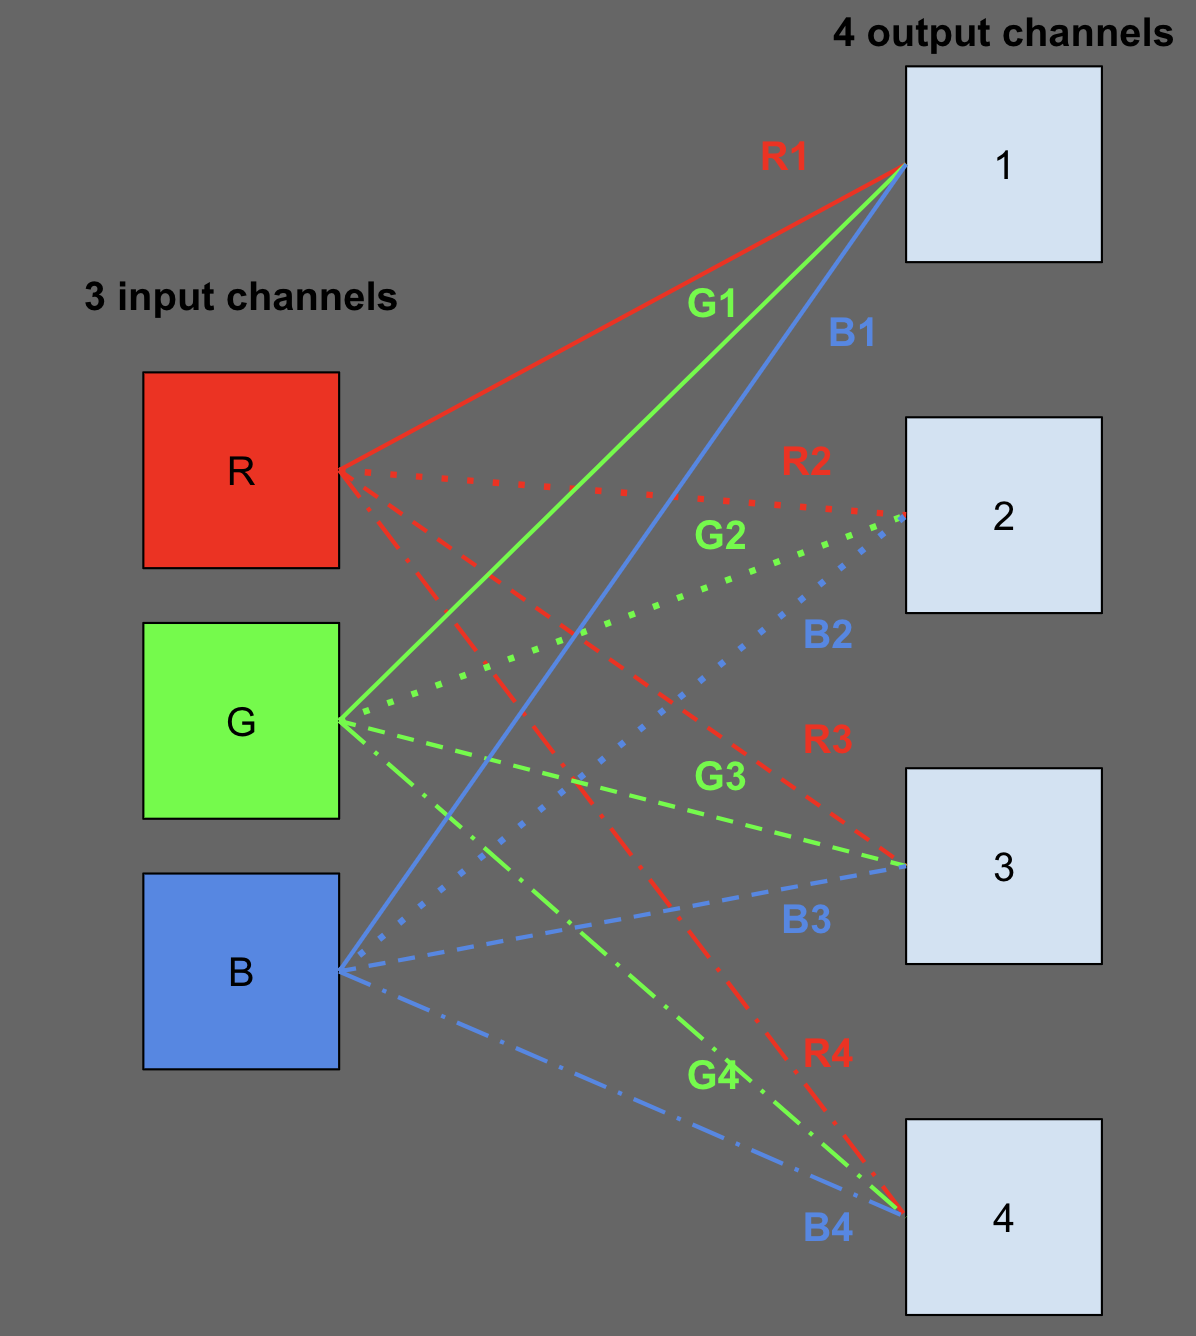

In [21]:
Image('multiInOut.png', width=400)

> ### Visualization of Multiple Input and Output Channels

> Let's say we have 3 input channels (R, G, B) and 4 output channels (labeled 1 to 4). The diagram above illustrates how the mechanism works. Each output channel has 3 associated kernels — one for each input channel. For example, **Output Channel 1** uses the kernels **R1, G1, and B1**, which are applied to the red, green, and blue input channels, respectively.
**The results of these three convolutions are then summed to produce Output Channel 1.**
This process is repeated for each output channel — e.g., Output Channel 2 is formed from R2, G2, B2, and so on through R4, G4, B4.

> Thus, with 3 input channels and 4 output channels, we have a total of **12 distinct kernels** ($c_i \times c_o$).
Assuming each kernel has size $k_h \times k_w$, the full convolutional kernel tensor is a fourth-order tensor with shape:

> $$
c_o \times c_i \times k_h \times k_w
$$

> Basically a matrix of matrices.

> When visualizing this structure, it's essential to recognize that **each output channel has its own unique set of kernels — one per input channel**.
Input channels **do not** have their own fixed kernels; they are shared across all output channels via different kernel sets.

> Also note that the multiple-input-multiple-output channel problem can be viewed as a multiple-input channel problem repeated independently for each output channel.

In [22]:
def corr2d_multi_in_out(X, K):
    # Iterate through the 0th dimension of K, and each time, perform
    # cross-correlation operations with input X. All of the results are
    # stacked together
    return torch.stack([corr2d_multi_in(X, k) for k in K], 0)

We construct a trivial convolution kernel with three output channels
by concatenating the kernel tensor for `K` with `K+1` and `K+2`.


In [23]:
K = torch.stack((K, K + 1, K + 2), 0)
K.shape

torch.Size([3, 2, 2, 2])

Below, we perform cross-correlation operations
on the input tensor `X` with the kernel tensor `K`.
Now the output contains three channels.
The result of the first channel is consistent
with the result of the previous input tensor `X`
and the multi-input channel,
single-output channel kernel.


In [24]:
corr2d_multi_in_out(X, K)

tensor([[[ 56.,  72.],
         [104., 120.]],

        [[ 76., 100.],
         [148., 172.]],

        [[ 96., 128.],
         [192., 224.]]])

## $1\times 1$ Convolutional Layer
:label:`subsec_1x1`

At first, a [**$1 \times 1$ convolution**], i.e., $k_\textrm{h} = k_\textrm{w} = 1$,
does not seem to make much sense.
After all, a convolution correlates adjacent pixels.
A $1 \times 1$ convolution obviously does not.
Nonetheless, they are popular operations that are sometimes included
in the designs of complex deep networks :cite:`Lin.Chen.Yan.2013,Szegedy.Ioffe.Vanhoucke.ea.2017`.
Let's see in some detail what it actually does.

Because the minimum window is used,
the $1\times 1$ convolution loses the ability
of larger convolutional layers
to recognize patterns consisting of interactions
among adjacent elements in the height and width dimensions.
The only computation of the $1\times 1$ convolution occurs
on the channel dimension.

:numref:`fig_conv_1x1` shows the cross-correlation computation
using the $1\times 1$ convolution kernel
with 3 input channels and 2 output channels.
Note that the inputs and outputs have the same height and width.
Each element in the output is derived
from a linear combination of elements *at the same position*
in the input image.
You could think of the $1\times 1$ convolutional layer
as constituting a fully connected layer applied at every single pixel location
to transform the $c_\textrm{i}$ corresponding input values into $c_\textrm{o}$ output values.
Because this is still a convolutional layer,
the weights are tied across pixel location.
Thus the $1\times 1$ convolutional layer requires $c_\textrm{o}\times c_\textrm{i}$ weights
(plus the bias). Also note that convolutional layers are typically followed
by nonlinearities (ReLU, tanh, Sigmoid,...). This ensures that $1 \times 1$ convolutions cannot simply be
folded into other convolutions.

> "Also note that convolutional layers are typically followed
by nonlinearities (ReLU, tanh, Sigmoid,...). This ensures that $1 \times 1$ convolutions cannot simply be
folded into other convolutions."

>> Recall that withotu nonlienar activation functions, the entire network will fold into single matrix-vector operation.
>> it is essential to apply activation after convolution layer and then go ahead with pooling or even another convolution layer.

![The cross-correlation computation uses the $1\times 1$ convolution kernel with three input channels and two output channels. The input and output have the same height and width.](https://github.com/d2l-ai/d2l-pytorch-colab/blob/master/img/conv-1x1.svg?raw=1)
:label:`fig_conv_1x1`

Let's check whether this works in practice:
we implement a $1 \times 1$ convolution
using a fully connected layer.
The only thing is that we need to make some adjustments
to the data shape before and after the matrix multiplication.


In [25]:
def corr2d_multi_in_out_1x1(X, K):
    c_i, h, w = X.shape
    c_o = K.shape[0]
    X = X.reshape((c_i, h * w))
    K = K.reshape((c_o, c_i))
    # Matrix multiplication in the fully connected layer
    Y = torch.matmul(K, X)
    return Y.reshape((c_o, h, w))

When performing $1\times 1$ convolutions,
the above function is equivalent to the previously implemented cross-correlation function `corr2d_multi_in_out`.
Let's check this with some sample data.


In [26]:
X = torch.normal(0, 1, (3, 3, 3))
K = torch.normal(0, 1, (2, 3, 1, 1))
Y1 = corr2d_multi_in_out_1x1(X, K)
Y2 = corr2d_multi_in_out(X, K)
assert float(torch.abs(Y1 - Y2).sum()) < 1e-6

## Discussion

Channels allow us to combine the best of both worlds: MLPs that allow for significant nonlinearities and convolutions that allow for *localized* analysis of features. In particular, channels allow the CNN to reason with multiple features, such as edge and shape detectors at the same time. They also offer a practical trade-off between the drastic parameter reduction arising from translation invariance and locality, and the need for expressive and diverse models in computer vision.

Note, though, that this flexibility comes at a price. Given an image of size $(h \times w)$, the cost for computing a $k \times k$ convolution is $\mathcal{O}(h \cdot w \cdot k^2)$. For $c_\textrm{i}$ and $c_\textrm{o}$ input and output channels respectively this increases to $\mathcal{O}(h \cdot w \cdot k^2 \cdot c_\textrm{i} \cdot c_\textrm{o})$. For a $256 \times 256$ pixel image with a $5 \times 5$ kernel and $128$ input and output channels respectively this amounts to over 53 billion operations (we count multiplications and additions separately). Later on we will encounter effective strategies to cut down on the cost, e.g., by requiring the channel-wise operations to be block-diagonal, leading to architectures such as ResNeXt :cite:`Xie.Girshick.Dollar.ea.2017`.

## Exercises

1. Assume that we have two convolution kernels of size $k_1$ and $k_2$, respectively
   (with no nonlinearity in between).
    1. Prove that the result of the operation can be expressed by a single convolution.
    > Let $x_0$ be the input and $x_1$ and $x_2$ be the outputs after the first and second convolution layers, respectively.
    > Then, after the first convolution, we have: $$x_1 = k_1x_0$$.
    > After the second convolution, we have: $$x_2 = k_2x_1$$ Which can be simplified to $$x_2 = k_2k_1x_0$$
    1. What is the dimensionality of the equivalent single convolution?
    > Recall the formula for computing the output shape of the convolution with 1-step stride and no padding with square input (n) and kernel (k) is:
    > $$
      (n - k+1)(n-k+1)
    $$
    > For simplicity, let's regard this as a 1D problem for now. Then, the first convolution will be:
    > $$n - k_1 + 1 = x_1$$
    > and the second convolution will be:
    > $$n-k_2+1 = x_1 - k_2+1 = n-k_1+1-k_2+1 = n - (k_1+k_2) +2$$
    > and we want this equal to $n - k_{eqi}+1$. Setting both to equal to each other gives us:
    > $$n - (k_1+k_2) +2= n-k_{eqi} + 1 \ →\ \mathbf{k_{eqi} = k_1+k_2-1}$$
    1. Is the converse true, i.e., can you always decompose a convolution into two smaller ones?
    > I don't think so. For example, let's say $k_1 = 3$ and $k_2 = 3$, so the effective combined kernel size is $k_s = 5$, according to our earlier formula:$$
k_s = k_1 + k_2 - 1
$$ Two separate 3×3 convolutions give us **18 parameters total** (9 + 9), while a single 5×5 convolution has **25 parameters**.
This means that the combined kernel from two 3×3s can only represent a **subset** of all possible 5×5 kernels. So although **combining** two small kernels increases receptive field, **decomposing** a general 5×5 kernel into two 3×3s is **not always possible** — there aren’t enough degrees of freedom.
> As a second example, consider $k_1 = 3$, $k_2 = 2$, which gives $k_s = 4$.
> Now the combined operation has $3 \times 3 + 2 \times 2 = 9 + 4 = 13$ parameters, while a full 4×4 kernel has **16 parameters**.
> Again, 13 < 16 — so only some 4×4 kernels can be expressed as a composition of 3×3 and 2×2 convolutions.
> This reinforces the idea that **the reverse (decomposition) is not always possible**, because smaller kernels give us **less representational capacity**.

1. Assume an input of shape $c_\textrm{i}\times h\times w$ and a convolution kernel of shape
   $c_\textrm{o}\times c_\textrm{i}\times k_\textrm{h}\times k_\textrm{w}$, padding of $(p_\textrm{h}, p_\textrm{w})$, and stride of $(s_\textrm{h}, s_\textrm{w})$.
    1. What is the computational cost (multiplications and additions) for the forward propagation?
    1. What is the memory footprint?
    1. What is the memory footprint for the backward computation?
    1. What is the computational cost for the backpropagation?
1. By what factor does the number of calculations increase if we double both the number of input channels
   $c_\textrm{i}$ and the number of output channels $c_\textrm{o}$? What happens if we double the padding?
1. Are the variables `Y1` and `Y2` in the final example of this section exactly the same? Why?
1. Express convolutions as a matrix multiplication, even when the convolution window is not $1 \times 1$.
1. Your task is to implement fast convolutions with a $k \times k$ kernel. One of the algorithm candidates
   is to scan horizontally across the source, reading a $k$-wide strip and computing the $1$-wide output strip
   one value at a time. The alternative is to read a $k + \Delta$ wide strip and compute a $\Delta$-wide
   output strip. Why is the latter preferable? Is there a limit to how large you should choose $\Delta$?
1. Assume that we have a $c \times c$ matrix.
    1. How much faster is it to multiply with a block-diagonal matrix if the matrix is broken up into $b$ blocks?
    1. What is the downside of having $b$ blocks? How could you fix it, at least partly?


[Discussions](https://discuss.d2l.ai/t/70)
